<a href="https://colab.research.google.com/github/AhmedYounes94/AraBERT-Diacritic-experiment/blob/Adding-Diacritics-to-all-data/AraBERTv2_ANERCorp_Undiacritic_CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#AraBERT for NER - on ANERCorp

ANERCorp:https://link.springer.com/chapter/10.1007/978-3-540-70939-8_13

We are using ANERCorp with Camel splits

The first part uses the Trainer API to quickly train the model


The second part defines a custom model and training loop which should be identical



**For AraBERTv1 and V2 you need to use the custom scripts** since the datasets library with the pyarrow backend dont support using farasapy

In [ ]:
!pip install transformers
!pip install datasets
!pip install farasapy
!pip install pyarabic
!pip install seqeval
!pip install pytorch-crf
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 1.9MB 6.0MB/s 
     |████████████████████████████████| 3.2MB 40.0MB/s 
     |████████████████████████████████| 890kB 40.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=32bd3743cc6a2b9743680c5e5300b0663b124318c1732eb7d673a6be1ab60362
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 4.2MB/s 
     |████████████████████████████████| 20.7MB 1.5MB/s 
     |████████████████████████████████| 112kB 43.4MB/s 
     |████████████████████████████████| 245kB 44.4MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 112kB 2.2MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.10-cp37-none-any.whl size=113324 sha256=88c89973752e915e47f19d834c9c90bae5a13355

In [ ]:
# !unzip "/content/drive/MyDrive/ANERcorp-CamelLabSplits.zip"

#Reading Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
ANERCorp_path = '/content/drive/My Drive/data/'

excel_data = pd.read_excel(ANERCorp_path+'Final_ANERCorp.xlsx')
train, test = train_test_split(excel_data)
np.savetxt(ANERCorp_path+'Train.txt', train.values, fmt='%s' )
np.savetxt(ANERCorp_path+'Test.txt', test.values, fmt='%s' )

In [ ]:
# !head -n100 ./ANERcorp-CamelLabSplits/ANERCorp_CamelLab_train.txt

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
def read_ANERcorp(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      if line.split()[0]=='.':
        if len(sentence) > 0:
          data.append((sentence,label))
          sentence = []
          label = []
        continue
      splits = line.split()
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append((sentence,label))
  return data

In [ ]:
ANERCorp_path = '/content/drive/My Drive/data/'
# data_train = read_ANERcorp(ANERCorp_path+'diacritic_train.txt')
# data_test = read_ANERcorp(ANERCorp_path+'diacritic_test.txt')
data_train = read_ANERcorp(ANERCorp_path+'Train.txt')
data_test = read_ANERcorp(ANERCorp_path+'Test.txt')
data_all = read_ANERcorp(ANERCorp_path+'ANERCorp.txt')


In [ ]:
print(Counter([ label for sentence in data_test for label in sentence[1]]))
print(Counter([ label for sentence in data_train for label in sentence[1]]))

Counter({'O': 28343, 'B-LOC': 1100, 'B-PERS': 830, 'I-PERS': 705, 'B-ORG': 462, 'I-ORG': 348, 'B-MISC': 260, 'I-LOC': 149, 'I-MISC': 129})
Counter({'O': 85004, 'B-LOC': 3169, 'B-PERS': 2610, 'I-PERS': 1997, 'B-ORG': 1452, 'I-ORG': 950, 'B-MISC': 810, 'I-LOC': 437, 'I-MISC': 339})


In [ ]:
label_list = list(Counter([ label for sentence in data_test for label in sentence[1]]).keys())
print(label_list)

['O', 'B-ORG', 'B-LOC', 'B-PERS', 'I-PERS', 'I-MISC', 'B-MISC', 'I-ORG', 'I-LOC']


Training Sentence Lengths: 


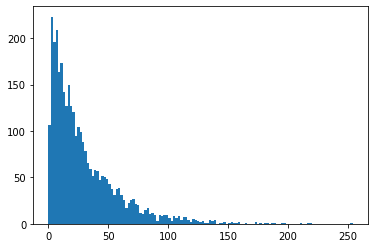

0
Testing Sentence Lengths: 


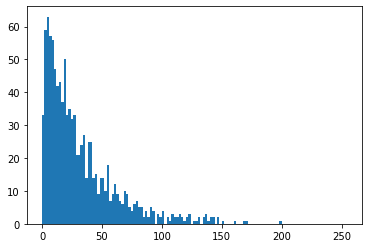

0


In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_train],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 512 for sentence in data_train]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in data_test],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in data_test]))

#NER with Trainer

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py

--2021-02-26 01:25:48--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/token-classification/run_ner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19188 (19K) [text/plain]
Saving to: ‘run_ner.py’

run_ner.py          100%[===================>]  18.74K  --.-KB/s    in 0.001s  

2021-02-26 01:25:48 (15.0 MB/s) - ‘run_ner.py’ saved [19188/19188]



Converting data to huggingface supported format
1 json per line with "tokens" and "ner_tags" as keys

close to this for format https://github.com/huggingface/transformers/blob/master/tests/fixtures/tests_samples/conll/sample.json

In [ ]:
import json

with open("train_data.json", "w") as outfile:
  for examples in data_train:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

with open("test_data.json", "w") as outfile:
  for examples in data_test:
    ex_dict = {
        "tokens":examples[0],
        "ner_tags":examples[1]
    }
    json.dump(ex_dict, outfile)
    outfile.write('\n')

In [ ]:
# !python run_ner.py \
#   --model_name_or_path aubmindlab/bert-large-arabertv02 \
#   --train_file train_data.json \
#   --validation_file test_data.json \
#   --output_dir ./test-ner \
#   --do_train \
#   --do_eval \
#   --per_device_train_batch_size 4 \
#   --gradient_accumulation_steps 8 \
#   --learning_rate 3e-5 \
#   --num_train_epochs 10 \
#   --warmup_steps 0 \
#   --evaluation_strategy epoch \
#   --save_steps 10000 \
#   --overwrite_output_dir \
#   --seed 42 \
#   --fp16 \

#NER with custom Model

##Model Files

In [ ]:

from sklearn import preprocessing
from sklearn import model_selection

from arabert.preprocess import ArabertPreprocessor, prefix_symbols , suffix_symblos

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import transformers
import torch

import torch.nn as nn
import numpy as np

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [ ]:
MAX_SEQ_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0
accumulation_steps = 1


#You can try other Arabic BERT models by just changing the path here
#In our tests AraBERT (v1&v0.1) outperformed all tested models :)
BASE_MODEL_PATH = 'aubmindlab/bert-base-arabertv02'
MODEL_PATH = "model.bin"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=False)
arabert_prep = ArabertPreprocessor(BASE_MODEL_PATH.split("/")[-1])

In [ ]:
tokenized_data = []
for sentence in data_test:
  tokenized_sentence = []
  for word in sentence[0]:
    tokenized_sentence.extend(TOKENIZER.tokenize(word))
  tokenized_data.append(tokenized_sentence)

#checking if Max length is compatible with the test data and doesnt cut any sentence in the test data weh
print(sum([len(sentence[0]) > MAX_SEQ_LEN for sentence in tokenized_data]))

0


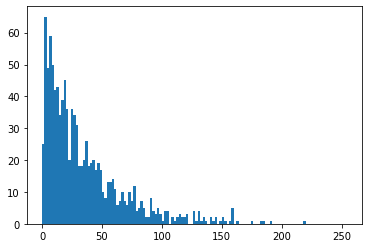

30


In [ ]:
# check if the test_dataset is fully covered
tokenized_data = [TOKENIZER.tokenize(arabert_prep.preprocess(" ".join(sentence[0]))) for sentence in data_test]
plt.hist([ len(x) for x in tokenized_data],bins=range(0,256,2))
plt.show()
print(sum([len(x) > MAX_SEQ_LEN for x in tokenized_data]))

In [ ]:
class NERDataset:
  def __init__(self, texts, tags, label_list, preprocessor):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = preprocessor    
    # self.pad_token_label_id = nn.CrossEntropyLoss().ignore_index
    self.pad_token_label_id = 0


    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = TOKENIZER.tokenize(clean_word)

      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = TOKENIZER.num_special_tokens_to_add()
    if len(tokens) > MAX_SEQ_LEN - special_tokens_count:
      tokens = tokens[: (MAX_SEQ_LEN - special_tokens_count)]
      label_ids = label_ids[: (MAX_SEQ_LEN - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [TOKENIZER.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [TOKENIZER.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = MAX_SEQ_LEN - len(input_ids)

    input_ids += [TOKENIZER.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == MAX_SEQ_LEN
    assert len(attention_mask) == MAX_SEQ_LEN
    assert len(token_type_ids) == MAX_SEQ_LEN
    assert len(label_ids) == MAX_SEQ_LEN

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)       
    }


In [ ]:
import torch.nn.functional as F
from torchcrf import CRF
log_soft = F.log_softmax


In [ ]:

word = torch.randn([32, 100, 768])
bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH)
out_tag = nn.Linear(768 , 9)        
crf = CRF(9, batch_first=True)


  

In [ ]:
# for data in tqdm(test_dataloader, total=len(test_dataloader)):
#         word = torch.randn([8, 128, 768])
#         out = out_tag(word)
#         logits = crf.decode(out)
#         # print(torch.Tensor(logits).shape)
#         # print(data['input_ids'].shape)
        

In [ ]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class NERModel(nn.Module):
    def __init__(self, num_tag):
        super(NERModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.AutoModel.from_pretrained(BASE_MODEL_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.out_tag = nn.Linear(self.bert.config.hidden_size, self.num_tag)
        self.crf = CRF(self.num_tag, batch_first=True)    

 
    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,output_hidden_states=True)
        bo_tag = self.bert_drop(output['last_hidden_state'])
        out = self.out_tag(bo_tag)
        # logits = self.out_tag(bo_tag)

        # loss_tag = loss_fn(logits, labels, attention_mask, self.num_tag)
        attention_mask = attention_mask.type(torch.uint8)
        loss_tag = -self.crf(log_soft(out, 2), labels, reduction='mean')
        logits = self.crf.decode(out)

        return loss_tag, logits

In [ ]:

inv_label_map = {i: label for i, label in enumerate(label_list)}

def align_predictions(predictions, label_ids):
    print('label_ids', label_ids[0])
    print('label_ids shape', label_ids.shape)
    print('predictions shape',predictions.shape)
    # preds = np.argmax(predictions, axis=2)
    preds = predictions

    print('preds',preds[0])
    print('preds shape',preds.shape)
  

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            # if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
            if label_ids[i, j] != 0:
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

def compute_metrics(predictions,label_ids):
    preds_list, out_label_list = align_predictions(predictions, label_ids)
    print(classification_report(out_label_list, preds_list,digits=4))
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for i, data in enumerate(tqdm(data_loader, total=len(data_loader))):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        # loss = outputs
        loss.backward()
        final_loss += loss.item()
        if (i + 1 ) % accumulation_steps == 0:
          torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
          optimizer.step()
          scheduler.step()          
          optimizer.zero_grad()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    with torch.no_grad():
      final_loss = 0
      preds= None
      labels = None
      for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        outputs = model(**data)
        loss = outputs[0]
        logits = torch.tensor(outputs[1],dtype=torch.long)
        final_loss += loss.item()
        if logits is not None:   
          preds = logits if preds is None else torch.cat((preds, logits), dim=0)
        if data['labels'] is not None:
          labels = data['labels'] if labels is None else torch.cat((labels, data['labels']), dim=0)
      preds = preds.detach().cpu().numpy()
      labels = labels.cpu().numpy()  
      # preds = logits.detach().cpu().numpy()
      # labels = labels.cpu().numpy()   
    
    return compute_metrics(preds,labels), final_loss
    # return compute_metrics(preds,labels)

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Fri Feb 26 01:54:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    70W / 149W |   8684MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                           

##Training on all the training data


In [ ]:

train_dataset = NERDataset(
    texts= [x[0] for x in data_train],
    tags = [x[1] for x in data_train],
    label_list = label_list,
    preprocessor=arabert_prep)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=2
)

test_dataset = NERDataset(
    texts= [x[0] for x in data_test],
    tags = [x[1] for x in data_test],
    label_list = label_list,
    preprocessor=arabert_prep)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

In [ ]:
EPOCHS = 8

In [ ]:
num_tag = len(label_list)
model = NERModel(num_tag=num_tag)
model.to(device)
print('MODEL LOADED!')

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
print('Number of training steps: ', num_train_steps)
optimizer = AdamW(optimizer_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(WARMUP_RATIO*num_train_steps), num_training_steps=num_train_steps
)

for epoch in range(EPOCHS):
    train_loss = train_fn(train_dataloader, model, optimizer, device, scheduler)
    eval_metrics, eval_loss = eval_fn(test_dataloader, model, device)
    print(f"Train Loss = {train_loss} Valid Loss = {eval_loss}")
    # eval_metrics = eval_fn(test_dataloader, model, device)
    # print(f"Train Loss = {train_loss}")
    print(eval_metrics)

MODEL LOADED!
Number of training steps:  1650


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



label_ids [0 0 0 0 0 1 0 0 0 2 3 0 0 0 0 0 0 2 0 4 0 5 0 0 0 0 0 0 0 6 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
label_ids shape (1040, 128)
predictions shape (1040, 128)
preds [0 0 0 0 0 1 0 0 0 2 4 0 0 0 0 0 0 2 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds shape (1040, 128)
              precision    recall  f1-score   support

         LOC     0.9221    0.7681    0.8381      1186
        MISC     0.9109    0.2548    0.3983       361
         ORG     0.6728    0.4566    0.5440       725
        PERS     0.7140    0.6285    0.6686      1311

   micro avg     0.7890    0.6023    0.6831      3583
   macro avg     0.8049    0.5270    0.6122      3583


label_ids [0 0 0 0 0 1 0 0 0 2 3 0 0 0 0 0 0 2 0 4 0 5 0 0 0 0 0 0 0 6 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
label_ids shape (1040, 128)
predictions shape (1040, 128)
preds [0 0 0 0 0 1 0 0 0 2 4 0 0 0 0 0 0 2 0 4 4 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds shape (1040, 128)
              precision    recall  f1-score   support

         LOC     0.9143    0.8094    0.8587      1186
        MISC     0.8153    0.3546    0.4942       361
         ORG     0.6702    0.6028    0.6347       725
        PERS     0.7589    0.6819    0.7184      1311

   micro avg     0.7965    0.6751    0.7308      3583
   macro avg     0.7897    0.6122    0.6765      3583


label_ids [0 0 0 0 0 1 0 0 0 2 3 0 0 0 0 0 0 2 0 4 0 5 0 0 0 0 0 0 0 6 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
label_ids shape (1040, 128)
predictions shape (1040, 128)
preds [0 0 0 0 0 1 0 0 0 2 4 0 0 0 0 0 0 2 0 4 4 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds shape (1040, 128)
              precision    recall  f1-score   support

         LOC     0.9103    0.8128    0.8588      1186
        MISC     0.7653    0.4155    0.5386       361
         ORG     0.7043    0.5683    0.6290       725
        PERS     0.7568    0.6834    0.7182      1311

   micro avg     0.8009    0.6760    0.7332      3583
   macro avg     0.7842    0.6200    0.6862      3583


label_ids [0 0 0 0 0 1 0 0 0 2 3 0 0 0 0 0 0 2 0 4 0 5 0 0 0 0 0 0 0 6 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
label_ids shape (1040, 128)
predictions shape (1040, 128)
preds [0 0 0 0 0 1 0 0 0 2 4 0 0 0 0 0 0 2 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds shape (1040, 128)
              precision    recall  f1-score   support

         LOC     0.9016    0.8187    0.8582      1186
        MISC     0.7624    0.4266    0.5471       361
         ORG     0.6954    0.5669    0.6246       725
        PERS     0.7676    0.7231    0.7447      1311

   micro avg     0.8000    0.6933    0.7428      3583
   macro avg     0.7817    0.6338    0.6936      3583


label_ids [0 0 0 0 0 1 0 0 0 2 3 0 0 0 0 0 0 2 0 4 0 5 0 0 0 0 0 0 0 6 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
label_ids shape (1040, 128)
predictions shape (1040, 128)
preds [0 0 0 0 0 1 0 0 0 2 4 0 0 0 0 0 0 2 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds shape (1040, 128)
              precision    recall  f1-score   support

         LOC     0.9180    0.8120    0.8617      1186
        MISC     0.7703    0.4460    0.5649       361
         ORG     0.7098    0.5600    0.6261       725
        PERS     0.7500    0.7368    0.7434      1311

   micro avg     0.8005    0.6966    0.7450      3583
   macro avg     0.7870    0.6387    0.6990      3583


label_ids [0 0 0 0 0 1 0 0 0 2 3 0 0 0 0 0 0 2 0 4 0 5 0 0 0 0 0 0 0 6 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
label_ids shape (1040, 128)
predictions shape (1040, 128)
preds [0 0 0 0 0 1 0 0 0 2 4 0 0 0 0 0 0 2 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
preds shape (1040, 128)
              precision    recall  f1-score   support

         LOC     0.9040    0.8179    0.8588      1186
        MISC     0.7659    0.4349    0.5548       361
         ORG     0.7169    0.5310    0.6101       725
        PERS     0.7672    0.7162    0.7408      1311

   micro avg     0.8065    0.6841    0.7403      3583
   macro avg     0.7885    0.6250    0.6911      3583

KeyboardInterrupt: ignored

In [ ]:
help(torch.from_numpy)

Help on built-in function from_numpy:

from_numpy(...)
    from_numpy(ndarray) -> Tensor
    
    Creates a :class:`Tensor` from a :class:`numpy.ndarray`.
    
    The returned tensor and :attr:`ndarray` share the same memory. Modifications to
    the tensor will be reflected in the :attr:`ndarray` and vice versa. The returned
    tensor is not resizable.
    
    It currently accepts :attr:`ndarray` with dtypes of ``numpy.float64``,
    ``numpy.float32``, ``numpy.float16``, ``numpy.complex64``, ``numpy.complex128``,
    ``numpy.int64``, ``numpy.int32``, ``numpy.int16``, ``numpy.int8``, ``numpy.uint8``,
    and ``numpy.bool``.
    
    Example::
    
        >>> a = numpy.array([1, 2, 3])
        >>> t = torch.from_numpy(a)
        >>> t
        tensor([ 1,  2,  3])
        >>> t[0] = -1
        >>> a
        array([-1,  2,  3])



#Results and hyper parameters

AraBERTv1

                  precision    recall  f1-score   support

             LOC     0.8919    0.9275    0.9094       676
            MISC     0.7389    0.6173    0.6726       243
             ORG     0.7748    0.6972    0.7339       459
            PERS     0.8499    0.8320    0.8409       905

       micro avg     0.8390    0.8103    0.8244      2283
       macro avg     0.8139    0.7685    0.7892      2283
    weighted avg     0.8354    0.8103    0.8217      2283

    Train Loss = 0.02561288744304329
    Valid Loss = 18.984092206461355
    'accuracy_score': 0.9703493257572726
    'precision': 0.8390022675736961
    'recall': 0.8103372755146737
    'f1': 0.8244206773618539

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 5
    LEARNING_RATE = 7e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0

AraBERTv0.2

                precision    recall  f1-score   support

           LOC     0.8886    0.9320    0.9097       676
          MISC     0.7590    0.6091    0.6758       243
           ORG     0.7935    0.7451    0.7685       459
          PERS     0.8832    0.8442    0.8633       905

      micro avg     0.8564    0.8252    0.8405      2283
      macro avg     0.8311    0.7826    0.8043      2283
      weighted avg     0.8536    0.8252    0.8380      2283

      Train Loss = 0.018847705767024308
      Valid Loss = 18.27915945305722
      'accuracy_score': 0.9722211071414235
      'precision': 0.8563636363636363
      'recall': 0.8252299605781866
      'f1': 0.8405085879991078

      MAX_SEQ_LEN = 256
      TRAIN_BATCH_SIZE = 32
      VALID_BATCH_SIZE = 8
      EPOCHS = 6
      LEARNING_RATE = 5e-5
      WARMUP_RATIO = 0.1
      MAX_GRAD_NORM = 1.0

AraELECTRA

                  precision    recall  f1-score   support

             LOC     0.8914    0.9349    0.9126       676
            MISC     0.7241    0.6049    0.6592       243
             ORG     0.8292    0.7298    0.7764       459
            PERS     0.8908    0.8475    0.8686       905

        micro avg     0.8640    0.8239    0.8435      2283
        macro avg     0.8339    0.7793    0.8042      2283
     weighted avg     0.8609    0.8239    0.8408      2283

    Train Loss = 0.012127994215115906
    Valid Loss = 20.18689019192243
    'accuracy_score': 0.9724218216851993
    'precision': 0.8640330730362885
    'recall': 0.823915900131406
    'f1': 0.8434977578475337}

    MAX_SEQ_LEN = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 10 # only 9 needed
    LEARNING_RATE = 5e-5
    WARMUP_RATIO = 0.1
    MAX_GRAD_NORM = 1.0